In [1]:
# Import Packages
#########################################################################################################################
import pandas as pd, numpy as np
from sqlalchemy import create_engine, MetaData, Table, select
import os, time
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [128]:
df = pd.read_csv('data.csv')

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Before Analyzing lets start by deduping the data set

In [129]:
df = df.drop(['Unnamed: 0'], axis=1)

In [130]:
df = df.drop_duplicates()

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503586 entries, 0 to 513230
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   tconst             503586 non-null  object 
 1   directors          459020 non-null  object 
 2   writers            414458 non-null  object 
 3   titleType          503586 non-null  object 
 4   primaryTitle       503586 non-null  object 
 5   isAdult            503586 non-null  int64  
 6   startYear          503543 non-null  float64
 7   runtimeMinutes     426299 non-null  float64
 8   genres             497136 non-null  object 
 9   category           459143 non-null  object 
 10  job                29099 non-null   object 
 11  primaryProfession  444316 non-null  object 
 12  knownForTitles     455954 non-null  object 
 13  averageRating      503586 non-null  float64
 14  numVotes           503586 non-null  int64  
dtypes: float64(3), int64(2), object(10)
memory usage: 6

In [132]:
df['isAdult'] = pd.Categorical(df['isAdult'])

### Bivariate Analysis for numerical variables 

In [133]:
corr = df.corr()

In [134]:
corr

,startYear,runtimeMinutes,averageRating,numVotes
startYear,1.000000,0.015412,0.142193,0.025265
runtimeMinutes,0.015412,1.000000,-0.068692,0.035455
averageRating,0.142193,-0.068692,1.000000,0.033647
numVotes,0.025265,0.035455,0.033647,1.000000


<AxesSubplot:>

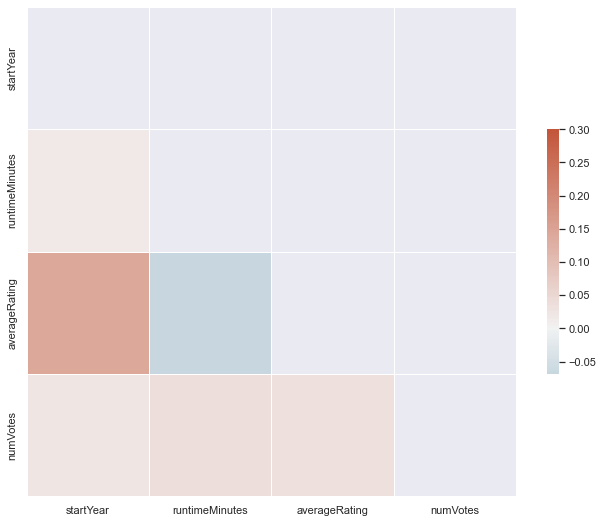

In [135]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

###### From the Chart we can conclude that there is hardly any correlation between the numerical variables and hence we can keep all

### Univariate & Bivariate Analysis for Categorical variables 

In [136]:
df_cat = df.select_dtypes(include = 'object').copy()

In [137]:
df_cat.head()

,tconst,directors,writers,titleType,primaryTitle,genres,category,job,primaryProfession,knownForTitles
0,tt0000001,nm0005690,NaN,short,Carmencita,"Documentary,Short",NaN,NaN,NaN,NaN
1,tt0000002,nm0721526,NaN,short,Le clown et ses chiens,"Animation,Short",NaN,NaN,NaN,NaN
2,tt0000005,nm0005690,NaN,short,Blacksmith Scene,"Comedy,Short",NaN,NaN,NaN,NaN
3,tt0000005,nm0005690,NaN,short,Blacksmith Scene,"Comedy,Short",actor,NaN,actor,tt0000005
6,tt0000006,nm0005690,NaN,short,Chinese Opium Den,Short,NaN,NaN,NaN,NaN


#### Finding out the percentage of missing values in the categorical data set

In [138]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

In [139]:
missing_value_df.sort_values('percent_missing', inplace=True)

In [140]:
missing_value_df

,column_name,percent_missing
tconst,tconst,0.000000
titleType,titleType,0.000000
primaryTitle,primaryTitle,0.000000
isAdult,isAdult,0.000000
averageRating,averageRating,0.000000
numVotes,numVotes,0.000000
startYear,startYear,0.008539
genres,genres,1.280814
category,category,8.825305
directors,directors,8.849730


In [141]:
df_cat['averageRating'] = df.loc[df_cat.index, 'averageRating'].copy()

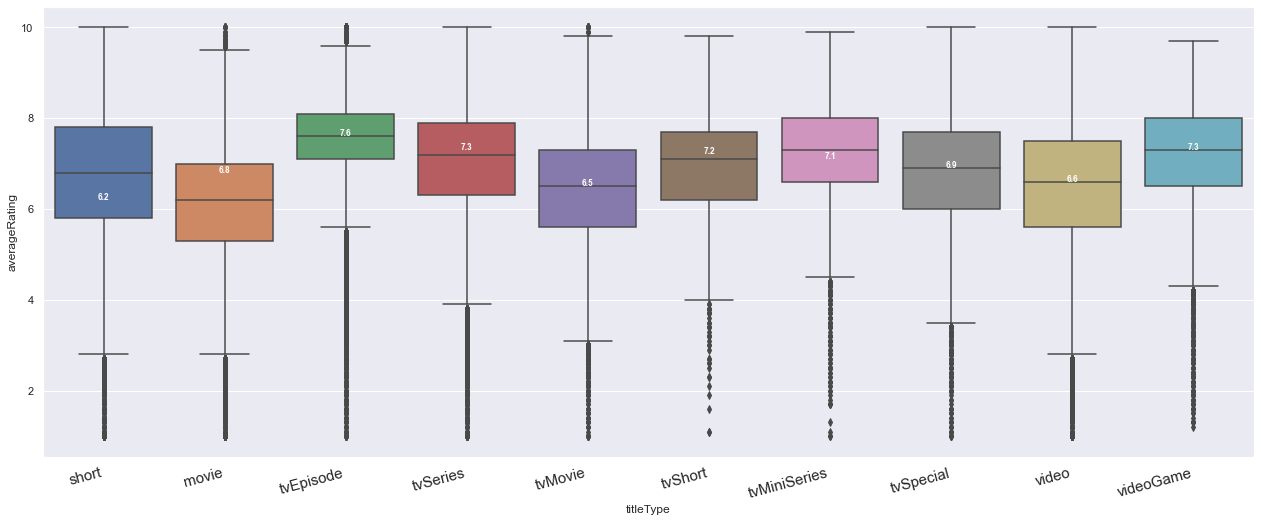

In [142]:
ax = sns.boxplot(data = df_cat, x='titleType', y='averageRating')
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right", fontsize=15)
sns.set(rc={'figure.figsize':(21.7,8.27)})
medians = df.groupby(['titleType'])['averageRating'].median()
vertical_offset = df['averageRating'].median() * 0.001 # offset from median for display

for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

In [143]:
df_cat['category'].nunique()

12

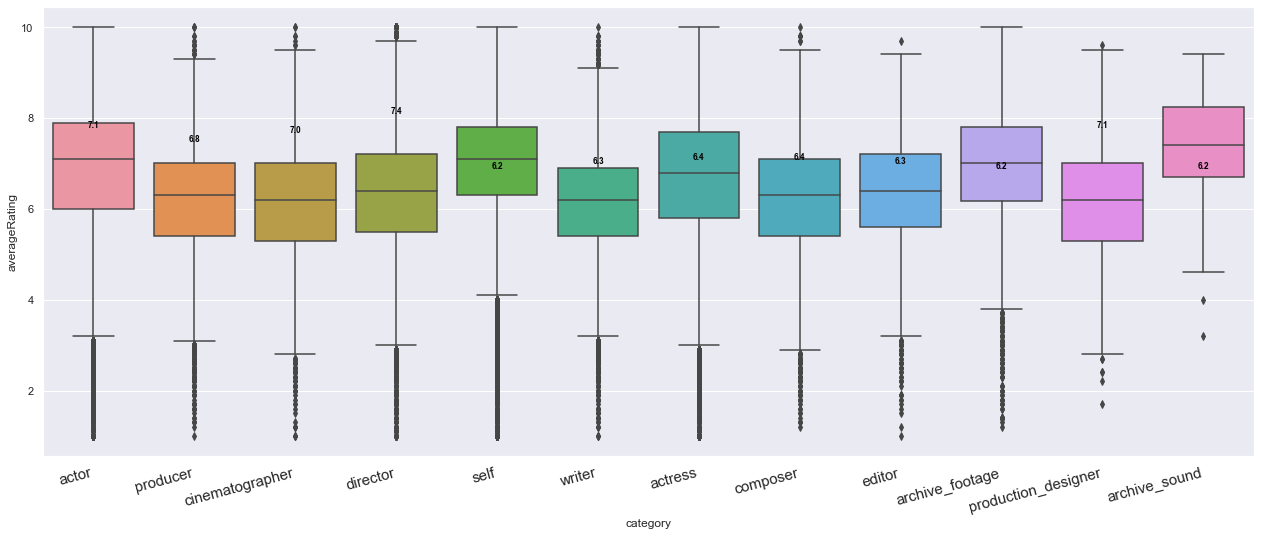

In [144]:
ax = sns.boxplot(data = df_cat, x='category', y='averageRating')
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right", fontsize=15)
sns.set(rc={'figure.figsize':(21.7,8.27)})
medians = df.groupby(['category'])['averageRating'].median()
vertical_offset = df['averageRating'].median() * 0.1 # offset from median for display

for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='black',weight='semibold')

### Handling genre and knownfor title variable

#### Adding a varibale which has the total number of genres

In [145]:
df['numberofgenre'] = df['genres'].str.count(',') + 1
df['numberofwriters'] = df['writers'].str.count(',') + 1
df['numberofdirectors'] = df['directors'].str.count(',') + 1

#### An idea to give plus points if a title is known and does not match with tconst

In [146]:
#df['Plus'] = df['tconst'] == df['knownForTitles']

In [147]:
#df[(df['Plus'] == 'FALSE') & ( df['knownForTitles'].notnull())]

#### But there exists no records like that hence will convert knownForTitles as a flag

In [148]:
df['knownForTitles'] = np.where(df['knownForTitles'].isnull(), 0, 100000)

In [149]:
df.head()

,tconst,directors,writers,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres,category,job,primaryProfession,knownForTitles,averageRating,numVotes,numberofgenre,numberofwriters,numberofdirectors
0,tt0000001,nm0005690,NaN,short,Carmencita,0,1894.0,1.0,"Documentary,Short",NaN,NaN,NaN,0,5.7,1858,2.0,NaN,1.0
1,tt0000002,nm0721526,NaN,short,Le clown et ses chiens,0,1892.0,5.0,"Animation,Short",NaN,NaN,NaN,0,6.0,243,2.0,NaN,1.0
2,tt0000005,nm0005690,NaN,short,Blacksmith Scene,0,1893.0,1.0,"Comedy,Short",NaN,NaN,NaN,0,6.2,2455,2.0,NaN,1.0
3,tt0000005,nm0005690,NaN,short,Blacksmith Scene,0,1893.0,1.0,"Comedy,Short",actor,NaN,actor,100000,6.2,2455,2.0,NaN,1.0
6,tt0000006,nm0005690,NaN,short,Chinese Opium Den,0,1894.0,1.0,Short,NaN,NaN,NaN,0,5.2,163,1.0,NaN,1.0


In [150]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
tconst,tconst,0.000000
numVotes,numVotes,0.000000
titleType,titleType,0.000000
primaryTitle,primaryTitle,0.000000
isAdult,isAdult,0.000000
averageRating,averageRating,0.000000
knownForTitles,knownForTitles,0.000000
startYear,startYear,0.008539
numberofgenre,numberofgenre,1.280814
genres,genres,1.280814


## Tackling Null Values
1) Will be dropping the column of **job** (has 94% missing values)and **primary profession**(since we alredy have category which talks about similar info)

2) will be filtering for data where **genre** and **startyear** is not null since it is like 1% of the data

3) Will have highest freq values for **directors**,**writers** and **category** and median value for **runtimeMinutes**

In [151]:
df = df[df['genres'].notnull()]

In [152]:
df = df[df['startYear'].notnull()]

In [153]:
df = df.drop(['job'], axis=1)

In [154]:
df = df.drop(['primaryProfession'], axis=1)

In [155]:
s = df.directors.value_counts(normalize=True)
df.loc[df.directors.isna(), 'directors'] = np.random.choice(s.index, p=s.values, size=df.directors.isna().sum())

In [156]:
s = df.writers.value_counts(normalize=True)
df.loc[df.writers.isna(), 'writers'] = np.random.choice(s.index, p=s.values, size=df.writers.isna().sum())

In [157]:
s = df.category.value_counts(normalize=True)
df.loc[df.category.isna(), 'category'] = np.random.choice(s.index, p=s.values, size=df.category.isna().sum())

In [158]:
df['runtimeMinutes'] = df['runtimeMinutes'].fillna(df['runtimeMinutes'].median())

In [159]:
df['numberofgenre'] = df['genres'].str.count(',') + 1
df['numberofwriters'] = df['writers'].str.count(',') + 1
df['numberofdirectors'] = df['directors'].str.count(',') + 1
df.head()

,tconst,directors,writers,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres,category,knownForTitles,averageRating,numVotes,numberofgenre,numberofwriters,numberofdirectors
0,tt0000001,nm0005690,"nm0731393,nm0383322,nm1549096,nm0287774",short,Carmencita,0,1894.0,1.0,"Documentary,Short",producer,0,5.7,1858,2,4,1
1,tt0000002,nm0721526,"nm1044431,nm2312213,nm3129892,nm3142583,nm2553325",short,Le clown et ses chiens,0,1892.0,5.0,"Animation,Short",self,0,6.0,243,2,5,1
2,tt0000005,nm0005690,"nm0920229,nm0792670,nm0002545,nm0943804",short,Blacksmith Scene,0,1893.0,1.0,"Comedy,Short",self,0,6.2,2455,2,4,1
3,tt0000005,nm0005690,nm6605976,short,Blacksmith Scene,0,1893.0,1.0,"Comedy,Short",actor,100000,6.2,2455,2,1,1
6,tt0000006,nm0005690,nm1543324,short,Chinese Opium Den,0,1894.0,1.0,Short,actor,0,5.2,163,1,1,1


In [160]:
genres_lists = df.genres.str.split(',')        
df.genres = genres_lists 
df = df.explode('genres')

In [161]:
directors_lists = df.directors.str.split(',')        
df.directors = directors_lists 
df = df.explode('directors')

In [162]:
writers_lists = df.writers.str.split(',')        
df.writers = writers_lists 
df = df.explode('writers')

### Handling of categorical variables before we start to model 
1) Use Target Encoding for **titleType** and **category**


2) Use Frequency Encoding for **primaryTitle** and **genres**

In [163]:
df['titleType'].unique()

array(['short', 'movie', 'tvEpisode', 'tvSeries', 'tvMovie', 'tvShort',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame'], dtype=object)

In [164]:
encodings = df.groupby('titleType')['averageRating'].mean().reset_index()
df = df.merge(encodings, how='left', on='titleType')
df.drop('titleType', axis=1, inplace=True)

In [165]:
df.rename(columns={'averageRating_x':'target_variable'}, inplace=True)

In [166]:
df.rename(columns={'averageRating_y':'titleType'}, inplace=True)

In [167]:
encodings = df.groupby('category')['target_variable'].mean().reset_index()
df = df.merge(encodings, how='left', on='category')
df.drop('category', axis=1, inplace=True)

In [168]:
df.rename(columns={'target_variable_x':'target_variable'}, inplace=True)
df.rename(columns={'target_variable_y':'category'}, inplace=True)

In [169]:
encodings = df.groupby('genres')['target_variable'].mean().reset_index()
df = df.merge(encodings, how='left', on='genres')
df.drop('genres', axis=1, inplace=True)

In [170]:
df.rename(columns={'target_variable_x':'target_variable'}, inplace=True)
df.rename(columns={'target_variable_y':'genres'}, inplace=True)

In [171]:
df.head()

,tconst,directors,writers,primaryTitle,isAdult,startYear,runtimeMinutes,knownForTitles,target_variable,numVotes,numberofgenre,numberofwriters,numberofdirectors,titleType,category,genres
0,tt0000001,nm0005690,nm0731393,Carmencita,0,1894.0,1.0,0,5.7,1858,2,4,1,6.654824,6.636118,7.813550
1,tt0000001,nm0005690,nm0383322,Carmencita,0,1894.0,1.0,0,5.7,1858,2,4,1,6.654824,6.636118,7.813550
2,tt0000001,nm0005690,nm1549096,Carmencita,0,1894.0,1.0,0,5.7,1858,2,4,1,6.654824,6.636118,7.813550
3,tt0000001,nm0005690,nm0287774,Carmencita,0,1894.0,1.0,0,5.7,1858,2,4,1,6.654824,6.636118,7.813550
4,tt0000001,nm0005690,nm0731393,Carmencita,0,1894.0,1.0,0,5.7,1858,2,4,1,6.654824,6.636118,6.690812


In [172]:
#pip install feature-engine

In [173]:
from feature_engine.encoding import CountFrequencyEncoder
encoder = CountFrequencyEncoder(encoding_method='frequency',
                         variables=['primaryTitle','directors','writers'])
encoder.fit(df)

CountFrequencyEncoder(encoding_method='frequency',
                      variables=['primaryTitle', 'directors', 'writers'])

In [174]:
df= encoder.transform(df)

In [176]:
df['primaryTitle'] = (df['primaryTitle'] - df['primaryTitle'].min()) / (df['primaryTitle'].max() - df['primaryTitle'].min())
df['directors'] = (df['directors'] - df['directors'].min()) / (df['directors'].max() - df['directors'].min())
df['writers'] = (df['writers'] - df['writers'].min()) / (df['writers'].max() - df['writers'].min())


In [177]:
df.head()

,tconst,directors,writers,primaryTitle,isAdult,startYear,runtimeMinutes,knownForTitles,target_variable,numVotes,numberofgenre,numberofwriters,numberofdirectors,titleType,category,genres
0,tt0000001,0.01849,0.055474,0.000006,0,1894.0,1.0,0,5.7,1858,2,4,1,6.654824,6.636118,7.813550
1,tt0000001,0.01849,0.061901,0.000006,0,1894.0,1.0,0,5.7,1858,2,4,1,6.654824,6.636118,7.813550
2,tt0000001,0.01849,0.019732,0.000006,0,1894.0,1.0,0,5.7,1858,2,4,1,6.654824,6.636118,7.813550
3,tt0000001,0.01849,0.063254,0.000006,0,1894.0,1.0,0,5.7,1858,2,4,1,6.654824,6.636118,7.813550
4,tt0000001,0.01849,0.055474,0.000006,0,1894.0,1.0,0,5.7,1858,2,4,1,6.654824,6.636118,6.690812


### Splitting the Data set into train, test 

In [180]:
import numpy as np
from sklearn.model_selection import train_test_split

In [181]:
X = df[['primaryTitle', 'isAdult','writers','directors',
       'startYear', 'runtimeMinutes', 'genres', 'knownForTitles',
       'numVotes', 'numberofgenre', 'numberofwriters',
       'numberofdirectors', 'titleType', 'category']]
y = df.target_variable

In [182]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
import statsmodels.api as sm

X_constant = sm.add_constant(X)
lin_reg = sm.OLS(y,X_constant).fit()
lin_reg.summary()

In [127]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

print(f'Coefficients: {lin_reg.coef_}')
print(f'Intercept: {lin_reg.intercept_}')
print(f'R^2 score: {lin_reg.score(X, y)}')

Coefficients: [ 0.00435446  0.01594585  0.15489232 -0.00216924  0.2282633  -0.00293181
  0.09955727  0.00224731 -0.00152034  0.00824728  0.54161936  0.05349152]
Intercept: 6.733606374272112
R^2 score: 0.23253104838005134


In [117]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 100 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [118]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.56 degrees.


In [124]:
from sklearn.metrics import r2_score

In [125]:
r2_score(predictions,y_test)

0.3291068745281608

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

KeyboardInterrupt: 

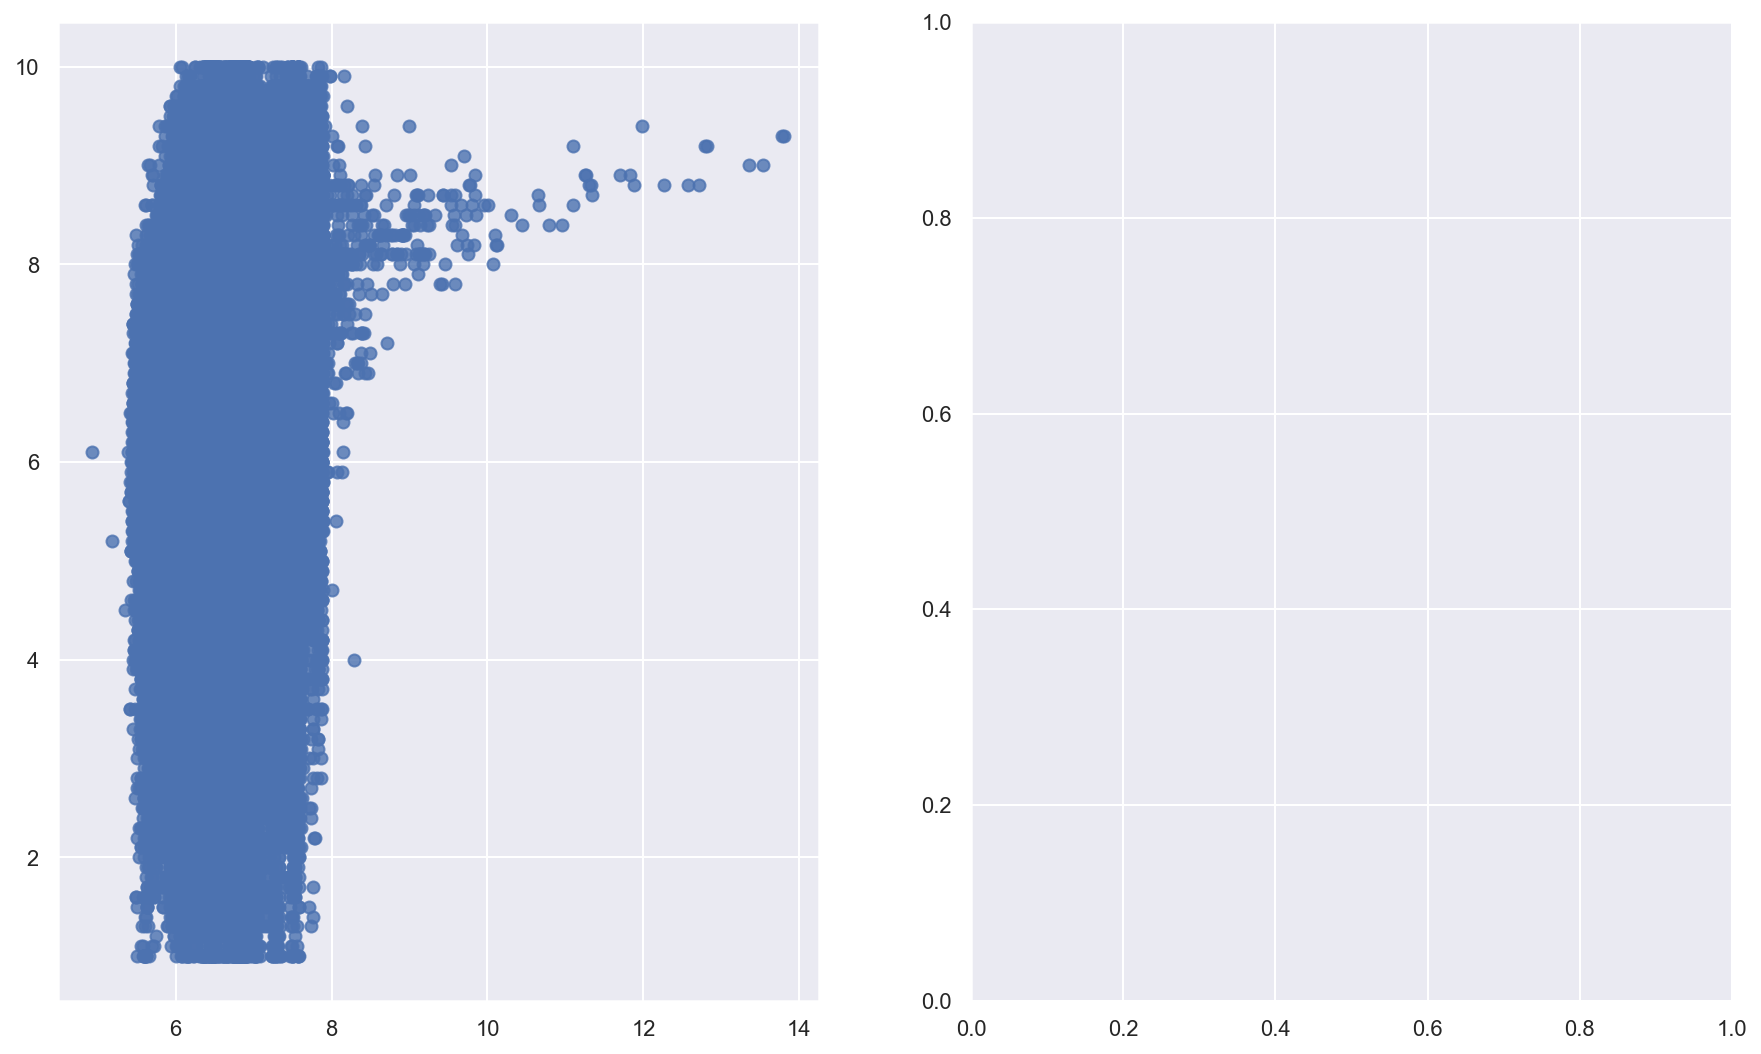

In [337]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(lin_reg, y)    
    

<AxesSubplot:>

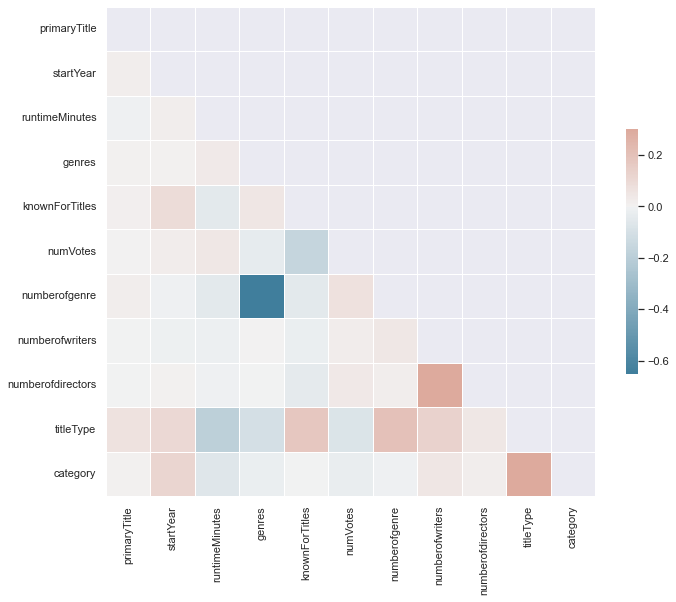

In [323]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Handling genre and knownForTitles variables ( This could be used later on if accuracy is less)

In [19]:
genres_lists = df.genres.str.split(',')        
df.genres = genres_lists 

In [20]:
genres_lists = df.genres.str.split(',')        
df.genres = genres_lists 
df = df.explode('genres')

In [24]:
knownForTitles_lists = df.knownForTitles.str.split(',')        
df.knownForTitles = knownForTitles_lists 

In [25]:
df = df.explode('knownForTitles')

In [27]:
df.describe()

,startYear,runtimeMinutes,averageRating,numVotes
count,3.483580e+06,3.008303e+06,3.483875e+06,3.483875e+06
mean,1.995936e+03,5.860408e+01,6.764852e+00,2.346812e+03
std,2.499134e+01,6.946736e+01,1.374452e+00,2.665700e+04
min,1.874000e+03,0.000000e+00,1.000000e+00,5.000000e+00
25%,1.986000e+03,2.400000e+01,6.000000e+00,2.100000e+01
50%,2.005000e+03,5.000000e+01,7.000000e+00,7.900000e+01
75%,2.014000e+03,8.900000e+01,7.800000e+00,3.720000e+02
max,2.022000e+03,5.142000e+04,1.000000e+01,2.543762e+06
